# Recreation of the statistical arbitrage figures on page 293 of "Algorithmic and High-Frequency Trading" By Cartea et. al.

## Notes:
* For their simulations, I think their normals have variance dt^2 instead of dt (probably just used a package that accepts the standard deviation as a parameter, and they passed in the variance)
* Their pi has an error: the term (tau * alpha / 2) should be (-tau * alpha)

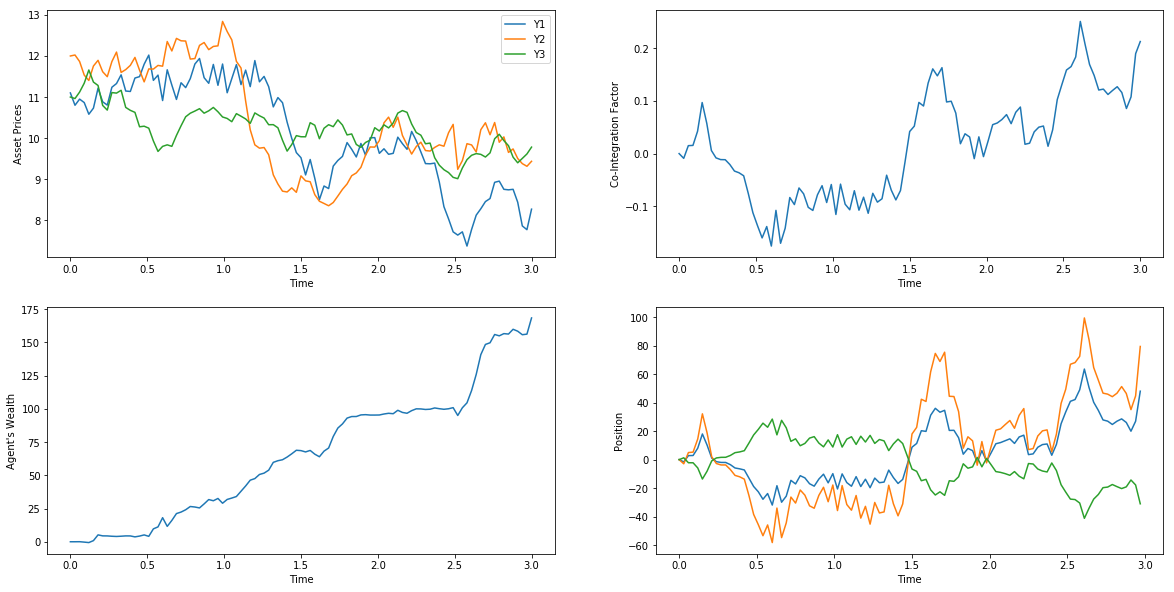

In [229]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

#set the parameters of the model
y0 = np.array([11.1, 12., 11.])
delta = np.array([1., 1., 0.])
a = np.array([-1., 0., 1.])
a0 = 0.
gamma = 0.01
sigma = np.array([[0.2, 0., 0.],
                  [0.0375, 0.1452, 0.],
                  [0.025, 0.0039, 0.0967]])

omega = sigma.dot(sigma.T)
theta = np.sum(np.multiply(a, np.diag(omega))) / (2 * delta.dot(a))

#set the parameters of the simulations
T = 3.
time_steps = 100
dt = T / time_steps
times = np.linspace(0, T, time_steps + 1)

#generate the Brownian motion increments
std_normals = np.random.normal(loc=0., scale=np.sqrt(dt), size=(len(y0), time_steps))
scaled_bm = sigma.dot(std_normals).T

#initialize variables for storing the paths
y_path = np.zeros(shape=(time_steps + 1, len(y0)))
y_path[0,:] = y0

alpha_path = np.zeros(time_steps + 1)
alpha_path[0] = a0

wealth_path = np.zeros(time_steps + 1)

positions = np.zeros(shape=(time_steps, len(y0)))

#precompute some terms we need to compute pi
omega_inv_dot_delta = np.linalg.inv(omega).dot(delta)
delta_omega_delta = delta.dot(omega).dot(delta)
trace_a_omega = np.sum(np.multiply(a, np.diag(omega)))

def get_pi(t, alpha):
    tau = T - t
    temp = - tau * alpha + 0.25 * trace_a_omega * tau * tau
    pi = (omega_inv_dot_delta * alpha + delta_omega_delta * temp * a) / gamma
    return pi

for i in range(0, time_steps):
    y = y_path[i,:]
    
    pi = get_pi(times[i], alpha_path[i])
    
    #TODO compare wealth to what happens if i just compute returns based on positions
    wealth_path[i+1] = wealth_path[i] + pi.dot(delta) * alpha_path[i] * dt + pi.dot(sigma).dot(scaled_bm[i,:])
    
    positions[i,:] = np.divide(pi, y)
    
    y_path[i+1,:] = y + np.multiply(delta, y) * alpha_path[i] * dt + np.multiply(y, scaled_bm[i,:])
    alpha_path[i + 1] = a0 + a.dot(np.log(y))
    
plt.rcParams["figure.figsize"] = (20,10)
    
plt.subplot(2, 2, 1)
plt.plot(times, y_path)
plt.xlabel('Time')
plt.ylabel('Asset Prices')
plt.legend(['Y1', 'Y2', 'Y3'])

plt.subplot(2, 2, 2)
plt.plot(times, alpha_path)
plt.xlabel('Time')
plt.ylabel('Co-Integration Factor')

plt.subplot(2, 2, 3)
plt.plot(times, wealth_path)
plt.xlabel('Time')
plt.ylabel('Agent\'s Wealth')

plt.subplot(2, 2, 4)
plt.plot(times[0:-1], positions)
plt.xlabel('Time')
plt.ylabel('Position')

plt.show()